In [1]:
import tensorflow as tf
import os
from tensorflow.python.data.experimental import AUTOTUNE
from PIL import Image
import matplotlib.pyplot as plt

from model.edsr import edsr
from train import EdsrTrainer
from model.wdsr import wdsr_b
from train import WdsrTrainer

%matplotlib inline

In [21]:
TRAIN_DIR = 'images/train'
train_img = []

for filename in os.listdir(TRAIN_DIR):
    if filename.endswith(".png"):
        img = Image.open(os.path.join(TRAIN_DIR, filename))
        w, h = img.size
        for _ in range(4 * w * h // 96 // 96):
            train_img.append(os.path.join(TRAIN_DIR, filename))

VAL_DIR = 'images/valid'
val_img = []

for filename in os.listdir(VAL_DIR):
    if filename.endswith(".png"):
        img = Image.open(os.path.join(VAL_DIR, filename))
        w, h = img.size
        for _ in range(4 * w * h // 96 // 96):
            val_img.append(os.path.join(VAL_DIR, filename))

In [22]:
def random_crop(lr_img, hr_img, hr_crop_size=96, scale=3):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(),
                             maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(),
                             maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)

In [23]:
def preprocess(filename):
    pil_img = Image.open(bytes.decode(filename.numpy()))
    h, w = pil_img.size
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    hr_img = tf.image.random_crop(img, size=(w // 3 * 3, h // 3 * 3, 3))
    lr_img = tf.image.resize(img, size=(w // 3, h // 3),
                             method=tf.image.ResizeMethod.BICUBIC)
    lr_img, hr_img = random_crop(lr_img, hr_img)
    lr_img, hr_img = random_flip(lr_img, hr_img)
    lr_img, hr_img = random_rotate(lr_img, hr_img)
    return lr_img, hr_img

In [24]:
def get_ds(train=True):
    ds = tf.data.Dataset.from_tensor_slices(train_img if train else val_img)
    ds = ds.map(lambda x: tf.py_function(func=preprocess,
                                         inp=[x], Tout=(tf.float32, tf.uint8)))
    ds = ds.batch(16)
    ds = ds.repeat(None if train else 1)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [25]:
train_ds = get_ds()
val_ds = get_ds(False)

In [7]:
# Number of residual blocks
depth = 32

# Super-resolution factor
scale = 3

# Downgrade operator
downgrade = 'bicubic'

In [26]:
trainer = WdsrTrainer(model=wdsr_b(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/wdsr-b-{depth}-x{scale}-aug-lanczos5')

Model restored from checkpoint at step 41100.


In [9]:
# trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth), 
#                       checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}-aug-lanczos5')

In [27]:
trainer.train(train_ds,
              val_ds,
              steps=100000, 
              evaluate_every=100, 
              save_best_only=True)

41200/100000: loss = 7.790, PSNR = 21.379097 (69.88s)
41300/100000: loss = 7.882, PSNR = 21.201181 (64.85s)
41400/100000: loss = 8.287, PSNR = 20.945347 (64.93s)
41500/100000: loss = 6.568, PSNR = 21.657345 (65.02s)
41600/100000: loss = 7.947, PSNR = 21.282562 (64.95s)
41700/100000: loss = 9.581, PSNR = 21.586094 (65.35s)
41800/100000: loss = 8.833, PSNR = 21.001944 (57.99s)
41900/100000: loss = 869.343, PSNR = 9.359390 (56.94s)
42000/100000: loss = 28.367, PSNR = 18.895538 (57.38s)
42100/100000: loss = 16.176, PSNR = 19.592459 (59.53s)
42200/100000: loss = 12.201, PSNR = 19.857401 (57.39s)
42300/100000: loss = 12.135, PSNR = 19.891689 (57.95s)
42400/100000: loss = 10.597, PSNR = 19.924021 (57.89s)
42500/100000: loss = 10.687, PSNR = 20.497835 (57.18s)
42600/100000: loss = 11.853, PSNR = 20.300213 (57.35s)
42700/100000: loss = 11.747, PSNR = 20.211590 (56.93s)
42800/100000: loss = 10.778, PSNR = 20.035467 (57.10s)
42900/100000: loss = 11.072, PSNR = 20.552614 (57.52s)
43000/100000: los

KeyboardInterrupt: 

In [11]:
trainer.restore()

Model restored from checkpoint at step 4400.


In [12]:
psnrv = trainer.evaluate(val_ds)
print(f'PSNR = {psnrv.numpy():3f}')

KeyboardInterrupt: 

In [13]:
#weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_dir = f'weights/wdsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights_aug_lanczos5.h5')

os.makedirs(weights_dir, exist_ok=True)

trainer.model.save_weights(weights_file)

## Test

In [14]:
model = wdsr_b(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [15]:
from model import resolve_single
from utils import load_image, plot_sample

from zipfile import ZipFile

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

def save(test_dir):
    with ZipFile('results.zip', 'w') as zipObj:
        for filename in os.listdir(test_dir):
            if not filename.endswith("png"):
                continue
            lr = load_image(os.path.join(test_dir, filename))
            sr = resolve_single(model, lr)
            image = Image.fromarray(sr.numpy())
            image.save(f'{filename[:2]}_pred.png', format='PNG')
            zipObj.write(f'{filename[:2]}_pred.png')

In [17]:
save('images/test')

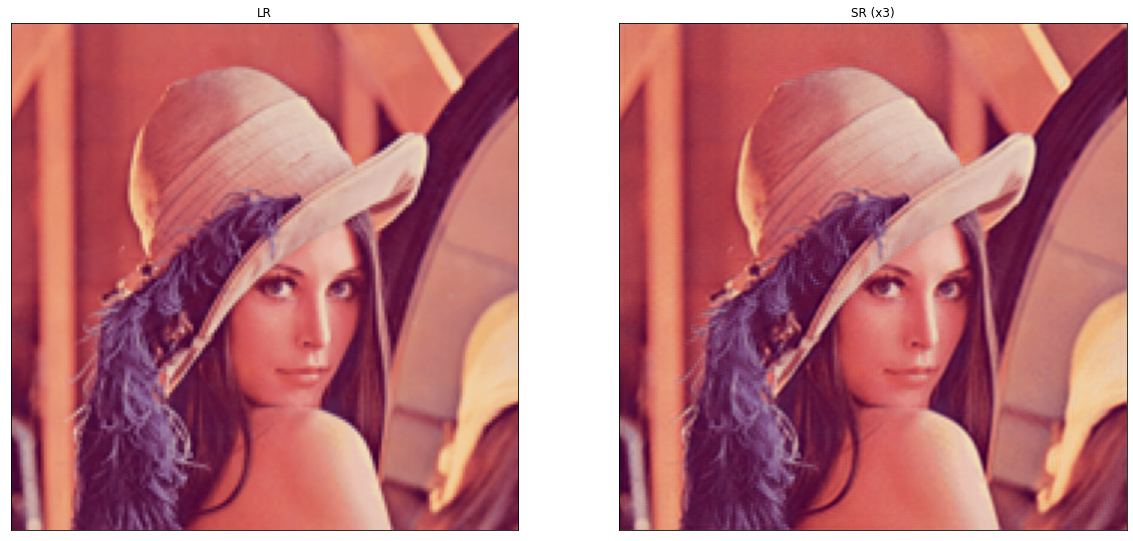

In [16]:
resolve_and_plot('images/test/01.png')